 In this Notebook an image of paleoclimate zones is processed to provide boundary conditions for paleoclimate simulations. Particularly to estimate global vegetation patterns for model configurations in which vegetation is not dynamically modeled but has to be prescribed. The paleoclimate zones have been drawn from distributions of various geologic and paleontologic proxies by [Boucot, Chen, Scotese and Morley (2013)](https://doi.org/10.2110/sepmcsp.11). The versions of these maps that are processed here are from C. R. Scotese (["Global_Climate_Change_Modern_Times_to_540_million_years_ago"](https://www.researchgate.net/publication/303811641_Global_Climate_Change_Modern_Times_to_540_million_years_ago)).
 
Preparing this information for the use in climate simulations involves several image processing operations to extract and clean features, as well as geographic transformations as the original images are in a Mollweide projection. These methods are common and useful in general geospatial data processing.

In [2]:
### General
import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os 

### Image processing
import cv2
import imageio
from PIL import Image,ImageOps
import skimage
from skimage import morphology

### Geospatial
import cartopy
import cartopy.crs as ccrs
import xarray as xr
import xesmf 
import geopandas
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal, osr, ogr # Python bindings for GDAL

# Extract Paleovegetation Boundary Conditions from Projected Map Image File

## Image Segmentation and Cleaning to Extract Paleoclimate Zones

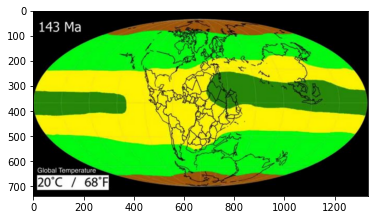

In [3]:
### Load the image from which the reconstructed paleoclimate zone will be extracted. 
### Credits: C. R. Scotese / Boucot et. al. 2013 (doi.org/10.2110/sepmcsp.11)

age_sel=143 # geologic time slice (in million years before today) that is considered here
img_file='./data/Scotese2016_PaleoclimateZones_{:03}Ma'.format(age_sel)
img = cv2.imread(img_file+'.png')
img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

plt.imshow(img)

,climzone_name,color_rgb,color_hsv,color_hsv_lowLim,color_hsv_upLim,color_rgb_lowLim,color_rgb_upLim
0,tropical,"[39, 135, 9]","[105, 93, 52]","[97, 44, 29]","[113, 100, 62]","[54, 73, 41]","[19, 159, 0]"
1,boreotropical,"[67, 189, 16]","[102, 91, 74]","[86, 0, 56]","[115, 100, 84]","[143, 143, 143]","[19, 215, 0]"
2,arid,"[255, 244, 2]","[57, 99, 100]","[44, 37, 27]","[68, 100, 100]","[69, 62, 43]","[219, 255, 0]"
3,warm,"[1, 252, 16]","[123, 99, 98]","[115, 13, 57]","[137, 100, 100]","[128, 146, 127]","[0, 255, 71]"
4,cool,"[158, 85, 9]","[30, 94, 61]","[12, 8, 0]","[44, 100, 100]","[0, 0, 0]","[255, 188, 0]"
5,polar,"[167, 199, 246]","[215, 32, 96]","[197, 4, 0]","[237, 44, 100]","[0, 0, 0]","[142, 147, 255]"
6,black,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 100, 27]","[0, 0, 0]","[0, 0, 0]"
7,white,"[255, 255, 255]","[0, 0, 100]","[0, 0, 25]","[104, 7, 100]","[63, 63, 63]","[255, 236, 236]"


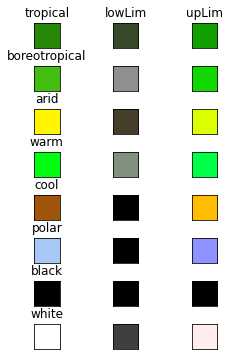

In [4]:
### These maps use a small set of colors for the main climate zones
### To be able to extract the patterns from the noisy image files, 
### we define the relevant RGB colors as well as upper/lower range values in HSV color space.

climate_zone_colors_df=pd.DataFrame([],columns=['climzone_name','color_rgb','color_hsv','color_hsv_lowLim','color_hsv_upLim','color_rgb_lowLim','color_rgb_upLim'],index=range(8))
climate_zone_colors_df['climzone_name']=['tropical','boreotropical' ,'arid','warm','cool','polar','black','white']

colors_rgb=np.array([
            [39, 135, 9],   # dark green - tropical
            [67, 189, 16],  # medium green - boreotropical
            [255, 244, 2],  # yellow - arid/subtropical
            [1, 252, 16],   # light green - warm            
            [158,85,9],     # brown - cool
            [167,199,246],  # light blue - polar
            [0,0,0],        # black
            [255,255,255]], # white
                    dtype=np.uint8) 

### limits estimated with the HSV color thresholder script (https://stackoverflow.com/a/60272927)
color_hsv_lowLims=np.array([
            [48,112,74 ],   # dark green - tropical
            [43,0,143 ],    # medium green - boreotropical
            [22,95,69 ],    # yellow - arid/subtropical
            [57,33,146 ],   # light green - warm            
            [6,20,0 ],      # brown - cool
            [98,10,0 ],     # light blue - polar
            [0,0,0 ],       # black
            [0,0,63 ]],     # white
                    dtype=np.uint8) 

color_hsv_upLims=np.array([
            [56,255,159 ],   # dark green - tropical
            [57,255,215 ],   # medium green - boreotropical
            [34,255,255 ],   # yellow - arid/subtropical
            [68,255,255 ],   # light green - warm            
            [22,255,255 ],   # brown - cool
            [118,113,255 ],  # light blue - polar
            [255,255,70 ],   # black
            [179,19,255 ]],  # white
                    dtype=np.uint8) 

colors_hsv=np.around(np.array(matplotlib.colors.rgb_to_hsv(colors_rgb/255)*np.array([360,100,100]),dtype=np.uint8)) #used this scaling for HSV thresholder script: *np.array([180,255,255])
colors_rgb_upLims=np.array(matplotlib.colors.hsv_to_rgb(color_hsv_upLims*np.array([1/179,1/255,1/255]))*255,dtype=np.uint8)
colors_rgb_lowLims=np.array(matplotlib.colors.hsv_to_rgb(color_hsv_lowLims*np.array([1/179,1/255,1/255]))*255,dtype=np.uint8)

climate_zone_colors_df['color_rgb']=list(colors_rgb)
climate_zone_colors_df['color_hsv']=list(colors_hsv)
climate_zone_colors_df['color_hsv_upLim']=list(np.array(np.around(color_hsv_upLims*np.array([360/179,100/255,100/255])),dtype=np.uint8))
climate_zone_colors_df['color_hsv_lowLim']=list(np.array(np.around(color_hsv_lowLims*np.array([360/179,100/255,100/255])),dtype=np.uint8))
climate_zone_colors_df['color_rgb_upLim']=list(colors_rgb_upLims)
climate_zone_colors_df['color_rgb_lowLim']=list(colors_rgb_lowLims)

### Visualize the defined colors
fig,axs=plt.subplots(len(climate_zone_colors_df.index),3,figsize=(4,6),facecolor='w')
axs_list=list(axs.flatten())
for aa in axs_list:
    aa.set_xticks([], [])
    aa.set_yticks([], [])
for idx,climzone in enumerate(climate_zone_colors_df.index):
    [col_rgb,col_rgb_lowLim,col_rgb_upLim,climzone_name]=climate_zone_colors_df.loc[climzone,['color_rgb','color_rgb_lowLim','color_rgb_upLim','climzone_name']]
    square=np.full((10, 10, 3), col_rgb, dtype=np.uint8) 
    square_lowLim=np.full((10, 10, 3), col_rgb_lowLim, dtype=np.uint8) 
    square_upLim=np.full((10, 10, 3), col_rgb_upLim, dtype=np.uint8) 
    axs[idx,0].imshow(square)
    axs[idx,1].imshow(square_lowLim)
    axs[idx,2].imshow(square_upLim)
    axs[idx,0].set_title(climzone_name)
axs[0,1].set_title('lowLim')
axs[0,2].set_title('upLim')
plt.subplots_adjust(hspace=0.7)

climate_zone_colors_df

/tmp/ipykernel_31016/981294345.py:26: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  mask_mod = np.array(1*skimage.morphology.remove_small_holes(mask_mod,area_threshold=2000),dtype=np.uint8)


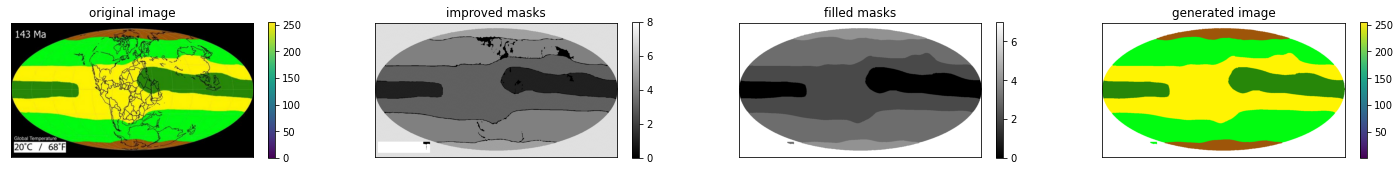

In [6]:
### Now the individual climate zones are axtracted from the image with the defined colors.
### However, this is complicated by the contintental contours and gridlines. These have to be removed, e.g. by morphological operations.
### Pixels which cannot directly be assigned one color / climate zone are filled considering their neighbourhood.

Ncol=len(climate_zone_colors_df.index) ### the number of colors that the image shall be separated into (=8)
masks=np.zeros((img.shape[0],img.shape[1],Ncol)) ### an array into which the binary masks for every color will be written

img_climate_zone_colors_df=pd.DataFrame([],columns=['climzone_name','color_rgb','mask'],index=climate_zone_colors_df.index,dtype=object)
img_climate_zone_colors_df[['climzone_name','color_rgb']]=climate_zone_colors_df[['climzone_name','color_rgb']]

### Looping over the defined set of colors
for ii in climate_zone_colors_df.index:
    
    ### selecting the pixels falling into the defined color range
    [color_rgb,color_hsv_lowLim,color_hsv_upLim]=climate_zone_colors_df.loc[ii,['color_rgb','color_hsv_lowLim','color_hsv_upLim']]
    color_hsv_lowLim=color_hsv_lowLim*np.array([179/360,255/100,255/100])
    color_hsv_upLim=color_hsv_upLim*np.array([179/360,255/100,255/100])
    mask = cv2.inRange(img_hsv, color_hsv_lowLim, color_hsv_upLim)  
    img_masked = cv2.bitwise_and(img, img, mask=mask)   
    img_climate_zone_colors_df.loc[ii,['mask']]=[mask] 
    if climate_zone_colors_df.loc[ii,['climzone_name']][0]=='black':
        mask = cv2.inRange(img, np.array([0,0,0],dtype=np.uint8), np.array([30,30,30],dtype=np.uint8)) ### for black, masking works better in RGB  
    
    ### automatically reduce artifacts in the maps, e.g. from contours of the tectonic plates, grid lines etc.
    mask_mod=np.array(1*(mask==255),dtype=np.uint8) 
    mask_mod = np.array(1*skimage.morphology.remove_small_holes(mask_mod,area_threshold=2000),dtype=np.uint8)
    
    mask_mod_labeled= skimage.measure.label(mask_mod,background=-1)    
    mask_mod_labeled = skimage.morphology.remove_small_objects(mask_mod_labeled,min_size=2000)
    mask_mod = np.array(1*(((mask_mod_labeled>0) & (mask_mod==1))),dtype=np.uint8)
    
    ### https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    kernel = np.ones((3,3),np.uint8)
    mask_mod = cv2.morphologyEx(mask_mod,cv2.MORPH_CLOSE,kernel, iterations = 1)
    mask_mod = cv2.morphologyEx(mask_mod,cv2.MORPH_OPEN,kernel, iterations = 1)  

    # fig,ax=plt.subplots(1,2,figsize=(8,4))  
    # a0=ax[0].imshow(mask,cmap='gray') 
    # a1=ax[1].imshow(mask_mod,cmap='gray') 
    # plt.colorbar(a0,ax=ax[0]) 
    # plt.colorbar(a1,ax=ax[1])
    
    ### store the modified masks for all colors in one array
    masks[:,:,ii]=(ii+1)*mask_mod

### choose the most frequent color in the 3x3 neighbourhood of each pixel
def Func(aa):
    bincount=np.bincount(aa[aa>0].astype('int').flatten())
    bb=bincount.argmax() 
    return bb 
img_climzones=scipy.ndimage.generic_filter(masks, Func, size=(3,3,Ncol),mode='wrap')[:,:,0] 

### fill gaps with most the frequent color in the neighbourhood (excluding black and white)
def Func2(aa):  
    bincount=np.bincount(aa[(aa>0) & (aa<7)].astype('int').flatten())
    if bincount.size:
        bb=bincount.argmax() 
    else:
        bb=8
    return bb
img_climzones_tmp=scipy.ndimage.generic_filter(img_climzones, Func2, size=40)
img_climzones_filled=np.where((img_climzones==0) & (img_climzones!=7) & (img_climzones!=8),img_climzones_tmp,img_climzones)
img_climzones_filled[img_climzones_filled==7]=8
img_climzones_filled=img_climzones_filled-1

### cv2.inpaint also fills gaps, but introduces additional values by averaging
# #https://stackoverflow.com/a/57099677
# mask = np.array(1.*(img_climzones==0),dtype=np.uint8)
# img_climzones_norm=np.array(255*img_climzones/img_climzones.max(),dtype=np.uint8)
# inpainted_img = cv2.inpaint(img_climzones_norm, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

### create a colored image from the extracted binary masks
img_result=np.empty(img.shape,dtype=np.uint8)
for ii in climate_zone_colors_df.index:
    for cc in range(3):
        img_result[:,:,cc]=np.where((img_climzones_filled==ii),np.ones(img_climzones.shape)*climate_zone_colors_df.loc[ii,['color_rgb']][0][cc],img_result[:,:,cc])

fig,ax=plt.subplots(1,4,num=11,figsize=(25,5),facecolor='w')
a0=ax[0].imshow(img)
a1=ax[1].imshow(img_climzones,cmap='gray')
a2=ax[2].imshow(img_climzones_filled,cmap='gray')
a3=ax[3].imshow(img_result)
plt.colorbar(a0,ax=ax[0],shrink=0.5)
plt.colorbar(a1,ax=ax[1],shrink=0.5)
plt.colorbar(a2,ax=ax[2],shrink=0.5)
plt.colorbar(a3,ax=ax[3],shrink=0.5)
ax[0].set_title('original image')
ax[1].set_title('improved masks')
ax[2].set_title('filled masks')
ax[3].set_title('generated image')
for aa in ax:
    aa.set_xticks([], [])
    aa.set_yticks([], [])



Comparing the first and the last two maps indicates that the climate zones were successfully extracted an cleaned.

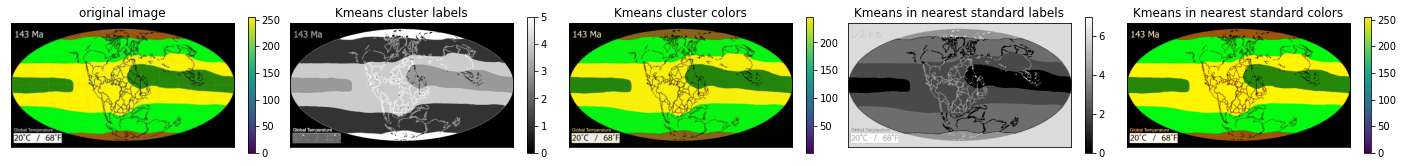

In [28]:
### Alternatively, one could do a Kmeans image segmentation rather than masking with the manually defined color ranges.
### In the following example, the standard colors defined above are still used for determining 
### the appropriate number of Kmeans clusters (how many different climate zones are actually represented in the map)
### and to initialize the Kmeans cluster centers (not necessary).

### check which climate zones / colors are represented in the map for the considered geologic time slice
colors_rgb_present=[]
for ii in climate_zone_colors_df.index:
    [mask,color_rgb]=img_climate_zone_colors_df.loc[ii,['mask','color_rgb']]    
    ### only consider colors making up for >1% of the total number of pixels
    if np.sum(mask/255)>0.01*mask.size:
        colors_rgb_present+=[list(color_rgb)]
        #print(climate_zone_colors_df.loc[ii,['climzone_name']][0]+' is present')    
colors_rgb_present=np.array(colors_rgb_present,dtype=np.uint8)

### https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/#1_Image_Segmentation_using_K-means
img_2D = img.reshape((-1,3))
img_2D = np.float32(img_2D)

### Options for the Kmeans algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.0001) #10, 1.0)
K = colors_rgb_present.shape[0] #7 #5
attempts=10

### Initial cluster centers provided to the Kmeans algorithm
labels_ini=np.random.randint(K,size=(img_2D.shape[0],1),dtype=np.int32)
centers_ini=colors_rgb_present

### Run the Kmeans clustering
ret, label, centers = cv2.kmeans(data=img_2D, K=K, criteria=criteria, attempts=attempts, 
                            flags=cv2.KMEANS_USE_INITIAL_LABELS, bestLabels=labels_ini, centers=centers_ini)
centers = np.uint8(centers)
res = centers[label.flatten()]
img_result_kmeans = res.reshape((img.shape))
img_labels_kmeans = label.reshape((img.shape[:2]))

### find out which of the pre-defined colors is closest to the Kmeans cluster centers
### https://ofstack.com/python/11731/python-implements-a-method-to-find-the-closest-approximation-to-a-given-color-from-a-set-of-colors.html

### calculate the squared euklidian distance between two color vectors in hsv space 
def func_color_dist( c1, c2): 
    c1 = c1*np.array([2*np.pi,1,1])
    c2 = c2*np.array([2*np.pi,1,1])
    dist=(np.sin(c1[0])*c1[1]*c1[2]-np.sin(c2[0])*c2[1]*c2[2])**2 + (np.cos(c1[0])*c1[1]*c1[2]-np.cos(c2[0])*c2[1]*c2[2])**2 + (c1[2]-c2[2])**2
    return dist

colors_standard_closest_idxs=np.empty(len(centers))
### Loop over the Kmeans cluster centers and find the closest of the defined standard colors
for ii,center in enumerate(centers):
    color_center_hsv = matplotlib.colors.rgb_to_hsv(centers[ii]/255) #(255,255,0)
    colors_standard_hsv=np.array(list(climate_zone_colors_df['color_hsv']))/np.array([360,100,100]) #matplotlib.colors.rgb_to_hsv(colors_rgb_present/255)
    color_distances=np.empty(colors_standard_hsv.shape[0])
    for cc,color_standard_hsv in enumerate(colors_standard_hsv):
        color_dist=func_color_dist(color_center_hsv,color_standard_hsv)
        color_distances[cc]=color_dist
    colors_standard_closest_idxs[ii]=color_distances.argmin()     
img_labels_standard=np.empty(img_labels_kmeans.shape)
for ii,center in enumerate(centers):
    img_labels_standard=np.where(img_labels_kmeans==ii,colors_standard_closest_idxs[ii],img_labels_standard)

### Create a color image with the segmentation from the Kmeans algorithm, using the closest defined standard colors    
img_result_kmeans_rgb=np.empty(img.shape,dtype=np.uint8)
for ii in climate_zone_colors_df.index:
    for cc in range(3):
        img_result_kmeans_rgb[:,:,cc]=np.where((img_labels_standard==ii),np.ones(img_labels_kmeans.shape)*climate_zone_colors_df.loc[ii,['color_rgb']][0][cc],img_result_kmeans_rgb[:,:,cc])
 
fig,axs=plt.subplots(1,5,figsize=(25,5),facecolor='w')
a0=axs[0].imshow(img)
a1=axs[1].imshow(img_labels_kmeans,cmap='gray')
a2=axs[2].imshow(img_result_kmeans)
a3=axs[3].imshow(img_labels_standard,cmap='gray')
a4=axs[4].imshow(img_result_kmeans_rgb)
plt.colorbar(a0,ax=axs[0],shrink=0.5)
plt.colorbar(a1,ax=axs[1],shrink=0.5)
plt.colorbar(a2,ax=axs[2],shrink=0.5)
plt.colorbar(a3,ax=axs[3],shrink=0.5)
plt.colorbar(a4,ax=axs[4],shrink=0.5)
axs[0].set_title('original image')
axs[1].set_title('Kmeans cluster labels')
axs[2].set_title('Kmeans cluster colors')
axs[3].set_title('Kmeans in nearest standard labels')
axs[4].set_title('Kmeans in nearest standard colors')

for aa in axs:
    aa.set_xticks([], [])
    aa.set_yticks([], [])
plt.subplots_adjust(wspace=0.0)  

### For further processing, the unwanted features would still needed to be removed as demonstrated above.
    

## Reproject the Original Mollweide Image to Obtain a Latitude-Longitude Raster

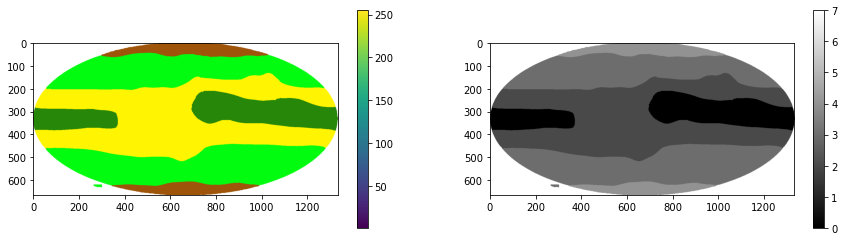

In [7]:
### Crop the cleaned image to enable correct reprojection
img_rgb_clean=img_result[34:701,:]
img_labels_clean=img_climzones_filled[34:701,:]

fig,axs=plt.subplots(1,2,figsize=(15,4),facecolor='w')
a0=axs[0].imshow(img_rgb_clean)
a1=axs[1].imshow(img_labels_clean,cmap='gray')
plt.colorbar(a0,ax=axs[0]);
plt.colorbar(a1,ax=axs[1]);


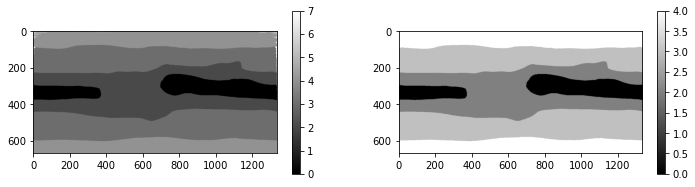

In [8]:
### Function for projecting raster image from Mollweide projection to an
### equirectangular coordinate system
def mollweide_to_equirectangular(arra):
    height, width = arra.shape
    result = coords =np.empty(arra.shape)   
    coords =np.empty([arra.shape[0],arra.shape[1],2])   
    for a in range(width):
        for b in range(height):            
            # image to coordinates
            x=(a*1./width-.5)*2*np.pi
            y=(b*1./height-.5)*np.pi            
            # Mollweide projection
            phi=np.copy(y)
            xn = 0
            old = xn+1.
            while abs(xn-old)>1e-6:
                old = xn
                xn = xn-(xn+np.sin(xn)-np.pi*np.sin(phi))/(1+np.cos(xn))
            th =xn/2            
            x=np.sqrt(8)*x*np.cos(th)/np.pi
            y=np.sqrt(2)*np.sin(th)  
            coords[b, a,:] = np.array([x, y])
            # coordinates to image
            xround = yround = np.floor
            if x<0: xround = lambda z: -np.floor(-z)
            if y<0: yround = lambda z: -np.floor(-z)
            x=xround((x/(2*np.sqrt(8))+.5)*width)
            y=yround((y/(2*np.sqrt(2))+.5)*height)    
            result[b, a] = arra[int(y-1), int(x-1)]             
    return result, coords

### Reproject the labeled image
img_labels_equirec, coords = mollweide_to_equirectangular(img_labels_clean)

### There are still some white pixels at the margins from distortions.
### Fill these gaps with most frequent climate zone color in the neighbourhood (excluding black and white)
def Func2(aa):  
    bincount=np.bincount(aa[(aa<6)].astype('int').flatten())
    if bincount.size:
        bb=bincount.argmax() 
    else:
        bb=7
    return bb
img_labels_equirec_tmp=scipy.ndimage.generic_filter(img_labels_equirec, Func2, size=40)
img_labels_equirec_filled=np.where((img_labels_equirec>=6),img_labels_equirec_tmp,img_labels_equirec)

fig,axs=plt.subplots(1,2,figsize=(12,5),num=1,facecolor='w')
a0=axs[0].imshow(img_labels_equirec,cmap='gray')
a1=axs[1].imshow(img_labels_equirec_filled,cmap='gray')
plt.colorbar(a0,ax=axs[0],shrink=0.6)
plt.colorbar(a1,ax=axs[1],shrink=0.6)

## Preparation for the Climate Model: Regrid and Assign Vegetation Fractions to the Reconstructed Paleoclimate Zones

/home/jan/miniconda3/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


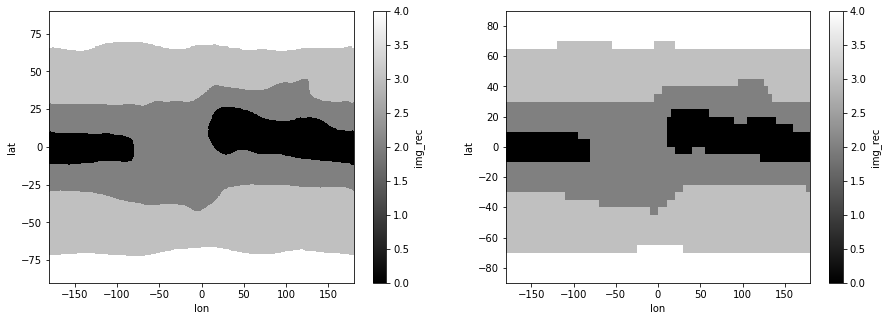

In [9]:
img_rec=np.copy(img_labels_equirec_filled)

### Put the obtained equirectangular image into an xarray Dataset
### for convenient regridding and further processing
dlat=180/img_rec.shape[0]
lats=np.arange(-90+0.5*dlat,90-0.5*dlat+dlat,dlat)[::-1]
dlon=360/img_rec.shape[1]
lons=np.arange(-180+0.5*dlon,180-0.5*dlon+dlon,dlon)
da= xr.DataArray(data   = img_rec,
                 dims   = ['lat', 'lon'],
                 coords = {'lat': lats, 'lon': lons})
ds=xr.Dataset({'img_rec': da})

### Regrid, e.g. to the 5°x5° horizontal grid resolution of the CLIMBER-X climate model
res=5
ds_out = xr.Dataset(
    {'lat': (['lat'], np.arange(-90+res/2, 90-res/2+res, res)[::-1]),
     'lon': (['lon'], np.arange(-180+res/2, 180-res/2+res, res))})
regridder = xesmf.Regridder(ds, ds_out, 'nearest_s2d')
# print(regridder)
ds_regrid= regridder(ds)

fig,axs=plt.subplots(1,2,figsize=(15,5),facecolor='w')
ds.img_rec.plot(ax=axs[0],cmap='gray')
ds_regrid.img_rec.plot(ax=axs[1],cmap='gray')

### we can store the xarray dataset as tif using rioxarray
# import rioxarray
# ds_renamed=ds.rename({'lon':'x','lat':'y'})
# ds_renamed.rio.to_raster(img_file+'_equirect.tif')

In [33]:
### We actually want vegetation patterns as boundary conditions for climate simulations without interactive vegetation.
### Assuming that the climate zones reconstructed from the proxies have very roughly corresponded to certain vegetation types, 
### certain tree and grass area fractions are assigned to the climate zones. 
### Trees, grass and bare soil are the simplified surface types that e.g. the CLimber-3alpha climate model can use. 

climzone_vegetation_df=pd.DataFrame([],index=img_climate_zone_colors_df.index)
climzone_vegetation_df['climzone_name']=img_climate_zone_colors_df['climzone_name']
climzone_vegetation_df['vegfrac_tree']= [0.75,0.75,0.15,0.7,0.65,0.15,0,0]
climzone_vegetation_df['vegfrac_grass']=[0.2, 0.2, 0.35,0.2,0.15,0.25,0,0]

climzone_vegetation_df

,climzone_name,vegfrac_tree,vegfrac_grass
0,tropical,0.75,0.20
1,boreotropical,0.75,0.20
2,arid,0.15,0.35
3,warm,0.70,0.20
4,cool,0.65,0.15
5,polar,0.15,0.25
6,black,0.00,0.00
7,white,0.00,0.00


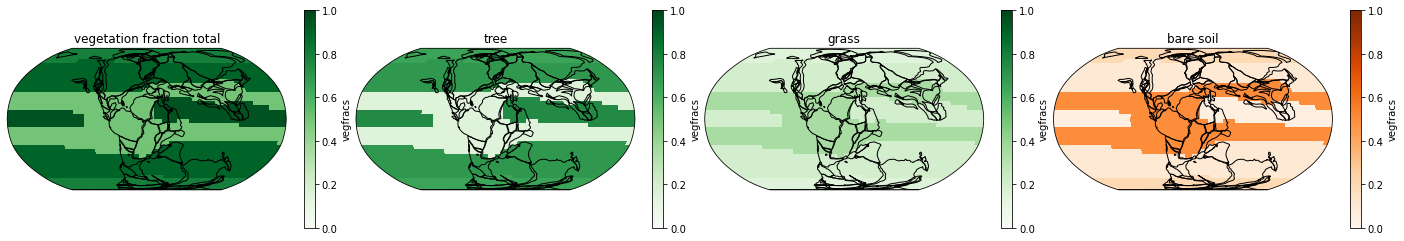

In [38]:
### With the extracted map of climate zones and the definition of corresponding vegetation characteristics,
### we can now generate arrays of vegetation fractions on a regular lat-lon grid that could serve as input to climate models. 

### Write fractions of tree, grass and bare soil coverage into one array, based on the reconstructed climate zones
img_vegfracs=np.empty([ds_regrid.img_rec.shape[0],ds_regrid.img_rec.shape[1],3])
for ii in climzone_vegetation_df.index:
    [vegfrac_tree,vegsfrac_grass]=climzone_vegetation_df.loc[ii,['vegfrac_tree','vegfrac_grass']]
    vegfrac_bare=1-vegfrac_tree-vegsfrac_grass ### the bare soil fraction is simply the unvegetated fraction
    vegfracs=[vegfrac_tree,vegsfrac_grass,vegfrac_bare]
    for jj in range(3):
        img_vegfracs[:,:,jj]=np.where(ds_regrid.img_rec.values==ii,vegfracs[jj],img_vegfracs[:,:,jj])

ds_regrid=ds_regrid.assign_coords(vegtype=np.arange(0,2+1,1))
ds_regrid['vegfracs']=(['lat','lon','vegtype'],img_vegfracs)

### Plot the surface type fractions
fig,axs=plt.subplots(1,4,subplot_kw={'projection': ccrs.Robinson()},facecolor='w',figsize=(25,4))
ds_regrid.vegfracs.isel(vegtype=[0,1]).sum(dim='vegtype').plot(ax=axs[0],cmap='Greens',vmin=0,vmax=1,transform=ccrs.PlateCarree())
for ii in range(2):
    ds_regrid.vegfracs.isel(vegtype=ii).plot(ax=axs[ii+1],cmap='Greens',vmin=0,vmax=1,transform=ccrs.PlateCarree())
ds_regrid.vegfracs.isel(vegtype=2).plot(ax=axs[3],cmap='Oranges',vmin=0,vmax=1,transform=ccrs.PlateCarree())
axs[0].set_title('vegetation fraction total');
axs[1].set_title('tree');
axs[2].set_title('grass');
axs[3].set_title('bare soil');
plt.subplots_adjust(wspace=0.0)

### Add contours of continent plates from shapefiles created with PyGPlates. 
### The underlying plate tectonic model was published by Cao et al. 2018 / C. R. Scotese (doi.org/10.1017/S0016756818000110)
sf=geopandas.read_file('./data/gplates_shapefiles_Scotese2008_Cao2018/{:03}Ma_reconstruction_polygons.shp'.format(age_sel))
for aa in axs:
    sf.plot(ax=aa,facecolor='None',transform=ccrs.PlateCarree())
### Alternative: opening/plotting the shapefile with Cartopy Shapereader
# reader = cartopy.io.shapereader.Reader('./data/gplates_shapefiles_Scotese2008_Cao2018/143Ma_reconstruction_polygons.shp')
# for rr in reader.records():
#     # print(rr)
#     shape_feature = cartopy.feature.ShapelyFeature([rr.geometry], ccrs.PlateCarree(), facecolor='None', edgecolor='black', lw=1)
#     for aa in axs:
#         aa.add_feature(shape_feature)
### Alternative: read sapefile with PyShp        
# import shapefile
# sf = shapefile.Reader('./data/143Ma_reconstruction_polygons.shp')
# for rr in sf.records():
#     print(rr)

In [39]:
sf

,ANCHOR,TIME,RECONFILE1,ANCHOR_1,TIME_1,FILE1,APPEARANCE,DISAPPEARA,PlateID,PLATEID2,GPGIM_TYPE,FEATURE_ID,L_PLATE,R_PLATE,SPREAD_ASY,PLATEID1,FROMAGE,TOAGE,geometry
0,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,0.0,0.0,327,0,gpml:UnclassifiedFeature,GPlates-9aef7a27-3c7b-4dfa-bd69-dfd9d0fe02b1,0,0,0.0,327,160.0,0.0,"POLYGON ((10.88795 53.55648, 10.50423 53.26250..."
1,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,145.0,-999.0,126,0,gpml:UnclassifiedFeature,GPlates-d86657ce-2664-43f2-b0ea-7c36999a6ba0,0,0,0.0,126,145.0,-999.0,"POLYGON ((-85.90384 39.58387, -86.10608 38.892..."
2,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,145.0,-999.0,198,0,gpml:UnclassifiedFeature,GPlates-ea08e82d-1ecf-4d6d-bc01-4228b10cc004,0,0,0.0,198,145.0,-999.0,"POLYGON ((-24.52731 -40.42011, -23.75263 -40.5..."
3,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,150.0,-999.0,101,0,gpml:UnclassifiedFeature,GPlates-bd8db911-eba5-4521-8425-3f925db03e93,0,0,0.0,101,150.0,-999.0,"POLYGON ((-25.02763 13.45694, -25.25792 13.170..."
4,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,165.0,-999.0,101,0,gpml:UnclassifiedFeature,GPlates-4b48d925-b31b-4dbb-a040-a34dd18ff1e9,0,0,0.0,101,165.0,-999.0,"POLYGON ((-31.10868 17.93057, -31.24857 17.407..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,4500.0,-999.0,811,0,gpml:UnclassifiedFeature,GPlates-7d129328-fc88-409e-8edf-966f27f712cd,0,0,0.0,811,600.0,-999.0,"POLYGON ((-40.09889 -55.17259, -40.41792 -55.3..."
155,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,4500.0,-999.0,872,0,gpml:UnclassifiedFeature,GPlates-3f0ca6e2-1470-477c-9b35-ff39d86b6abb,0,0,0.0,872,4500.0,-999.0,"POLYGON ((50.43815 -50.85384, 50.08185 -50.396..."
156,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,4500.0,-999.0,875,0,gpml:UnclassifiedFeature,GPlates-845439df-ea66-4c58-a595-95f0dc24082b,0,0,0.0,801,4500.0,-999.0,"POLYGON ((108.10747 -46.67019, 107.09785 -46.7..."
157,1,143.0,Scotese_2008_Rotation.rot,0,0.0,PALEOMAP_PlatePolygons.gpml,45000.0,-999.0,291,0,gpml:UnclassifiedFeature,GPlates-02a8fce7-2c2d-4617-841c-cbb5efbd245e,0,0,0.0,291,600.0,-999.0,"POLYGON ((-36.02024 -36.47337, -36.34058 -37.1..."


# Addition: Create a georeferenced GeoTiff Dataset for Further Processing

transform=
 | 0.27, 0.00,-179.87|
| 0.00,-0.27, 89.87|
| 0.00, 0.00, 1.00|
dataset metadata:
 {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1334, 'height': 667, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.26966276981449633, 0.0, -179.86506746626688,
       0.0, -0.2694604721627225, 89.86506746626905)}
GDAL Metadata:
 Driver: GTiff/GeoTIFF
Files: ./data/Scotese2016_PaleoclimateZones_143Ma_equirect_rasterio.tif
Size is 1334, 667
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data

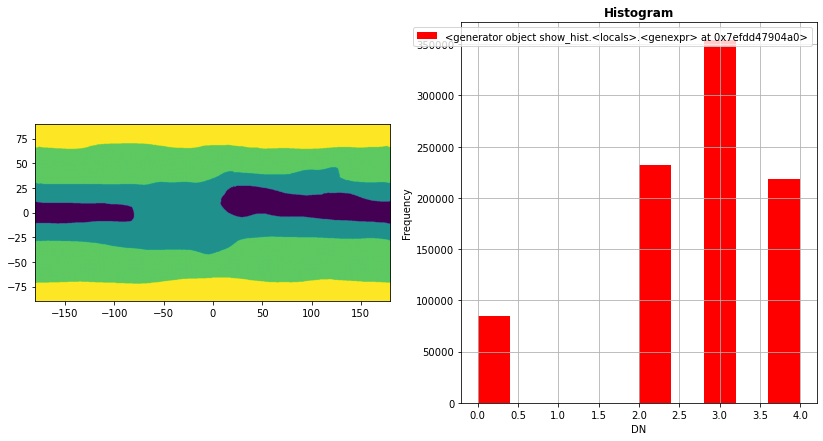

In [18]:
### Creating a GeoTiff using rasterio

x=ds.lon.values
y=ds.lat.values
ncols=len(x)
nlines=len(y)

### https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data
### https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/
#### https://gis.stackexchange.com/a/425874

### Construct rasterio transform object
# ### Variant 1:
# resx = (x[-1] - x[0]) / xsize
# resy = (y[-1] - y[0]) / ysize
# transform = rasterio.transform.Affine.translation(x[0]-resx/2, y[0]-resy/2) * rasterio.transform.Affine.scale(resx, resy)
### Variant 2:
transform = rasterio.transform.from_bounds(np.min(x), np.min(y), np.max(x), np.max(y),
                                           width=ncols, height=nlines)
print('transform=\n',transform)

#src = rasterio.open(img_file+'_equirect.tif')
ds_rio = rasterio.open(img_file+'_equirect_rasterio.tif','w',
                          driver='GTiff',
                          height=nlines,
                          width=ncols, 
                          count=1,
                          dtype=ds.img_rec.values.dtype,
                          crs='+proj=longlat', # works as well: crs=rasterio.crs.CRS.from_proj4('+proj=longlat') 
                          transform=transform,
                          compress='lzw')
ds_rio.write(ds.img_rec.values, 1)
ds_rio.close()
#print(src.bounds,src.transform,src.crs)

ds_rio = rasterio.open(img_file+'_equirect_rasterio.tif')
fig, axs = plt.subplots(1, 2, figsize=(14,7))
# plt.imshow(ds_rio.read(1))
show(ds_rio, ax=axs[0])
rasterio.plot.show_hist(ds_rio, ax=axs[1])

print('dataset metadata:\n',ds_rio.meta)
ds_gdal = gdal.Open(img_file+'_equirect_rasterio.tif')
info=gdal.Info(ds_gdal)
print('GDAL Metadata:\n',info)

In [19]:
##### Creating a GeoTiff using gdal
###https://geonetcast.wordpress.com/2022/05/12/creating-a-geotiff-from-a-numpy-array/

def getGeoTransform(extent, nlines, ncols):
    resx = (extent[2] - extent[0]) / ncols
    resy = (extent[3] - extent[1]) / nlines
    return [extent[0], resx, 0, extent[3] , 0, -resy]
 
# Define the data extent (min. lon, min. lat, max. lon, max. lat)
extent = [min(lons), min(lats), max(lons), max(lats)] 
 
# Get GDAL driver GeoTiff
driver = gdal.GetDriverByName('GTiff') 
# Create a temp grid
grid_data = driver.Create('grid_data', ncols, nlines, 1, gdal.GDT_Int16) 
# Write data for each bands
grid_data.GetRasterBand(1).WriteArray(ds.img_rec.values)
 
# Lat/Lon WSG84 Spatial Reference System
srs = osr.SpatialReference()
srs.ImportFromProj4('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs') 
# Setup projection and geo-transform
grid_data.SetProjection(srs.ExportToWkt())
grid_data.SetGeoTransform(getGeoTransform(extent, nlines, ncols))
 
# Save the file
driver.CreateCopy(img_file+'_equirect_gdal.tif', grid_data, 0,  options=['COMPRESS=LZW']) 
# Close the file
driver = None
grid_data = None 

# Delete the temp grid               
os.remove('grid_data')

ds_gdal = gdal.Open(img_file+'_equirect_gdal.tif')
info=gdal.Info(ds_gdal)
print(info)

Driver: GTiff/GeoTIFF
Files: ./data/Scotese2016_PaleoclimateZones_143Ma_equirect_gdal.tif
Size is 1334, 667
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.865067466266879,89.865067466269053)
Pixel Size = (0.269662769814496,-0.269460472162723)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.8650675,  89.8650675) (179d51'54.24"W, 89d51'54.24"N)
Lower Left  (-179.8650675, -89.8650675) (

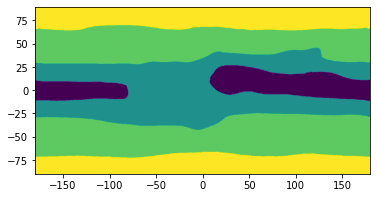

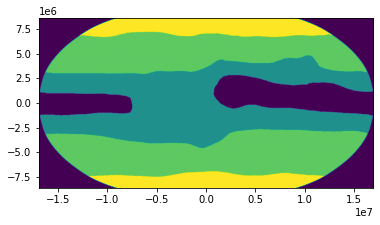

<AxesSubplot:>

In [20]:
### Reproject with gdal.Warp()

options=gdal.WarpOptions(dstSRS='ESRI:53030',format='GTiff',creationOptions=['COMPRESS=LZW']) #,creationOptions='COMPRESS=LZW'
geotiff_projected = gdal.Warp(img_file+'_projected_rasterio.tif', img_file+'_equirect_rasterio.tif',options=options) # ,options=options dstSRS='EPSG:4326' ,format='GeoTiff'
geotiff_projected=None
### Projections:
### ESRI:53030 Sphere_Robinson,  in Proj4: "+proj=robin" / "+proj=robin +lon_0=0 +x_0=0 +y_0=0 +R=6371000 +units=m +no_defs +type=crs"
### (does not work) ESRI:53009 Sphere_Mollweide, in Proj4: "+proj=moll +lon_0=0 +x_0=0 +y_0=0 +R=6371000 +units=m +no_defs +type=crs"

geotiff_equirect = rasterio.open(img_file+'_equirect_rasterio.tif')
geotiff_projected = rasterio.open(img_file+'_projected_rasterio.tif')
show(geotiff_equirect)
show(geotiff_projected)

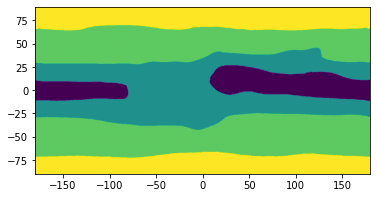

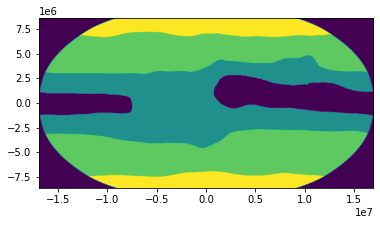

Equirect GeoTiff Metadata:
 {'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1334, 'height': 667, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.26966276981449633, 0.0, -179.86506746626688,
       0.0, -0.2694604721627225, 89.86506746626905)}
Projected GeoTiff Metadata:
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2027, 'height': 1028, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Sphere_Robinson",GEOGCS["Unknown datum based upon the Authalic Sphere",DATUM["Not_specified_based_on_Authalic_Sphere",SPHEROID["Sphere",6371000,0,AUTHORITY["EPSG","7035"]],AUTHORITY["EPSG","6035"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(16751.309410452574, 0.0, -16974070.427527953,
       0.0, -16751.

In [24]:
### Reproject with rasterio.warp
### https://rasterio.readthedocs.io/en/latest/topics/reproject.html

dst_crs = 'ESRI:53030' 

with rasterio.open(img_file+'_equirect_rasterio.tif') as src:
    transform, width, height = rasterio.warp.calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({ 'crs': dst_crs, 'transform': transform, 'width': width, 'height': height, 'compress': 'lzw', 'dtype': 'uint8' })

    with rasterio.open(img_file+'_projected_rasterio.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            rasterio.warp.reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=rasterio.warp.Resampling.nearest)
            
geotiff_equirect = rasterio.open(img_file+'_equirect_rasterio.tif')
geotiff_projected = rasterio.open(img_file+'_projected_rasterio.tif')
show(geotiff_equirect)
show(geotiff_projected)

print('Equirect GeoTiff Metadata:\n',geotiff_equirect.meta)
print('Projected GeoTiff Metadata:\n',geotiff_projected.meta)

In [ ]:
### Some further useful stuff:
###  https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
### https://stackoverflow.com/a/66534376

### projection:
#### https://gis.stackexchange.com/questions/432107/projection-mollweide-to-equirectangular
#### https://mathematica.stackexchange.com/questions/11834/how-do-i-map-a-mollweide-projection-onto-a-sphere
#### https://stackoverflow.com/questions/45108635/converting-latitude-longitude-to-x-y-mollweide-map-coordinates-using-a-newto